In [1]:
from pathlib import Path
import sys
sys.path.append('../')
from pma_open import *


#My image
file_path = '../Dropbox Files/hel1.pma'
image_path = "../Channel Mapping/hel1_Avg_Frame/hel1_Avg_Frame.png"
image = io.imread(image_path, as_gray=True)

#Chanel image paths
CH1_img_path = "../Channel Mapping/hel1_Avg_Frame/hel1_Avg_Frame_CH1.png"
CH2_img_path = "../Channel Mapping/hel1_Avg_Frame/hel1_Avg_Frame_CH2.png"

good_peaks_1,_ = good_peak_finder(CH1_img_path)
good_peaks_2_new,_ = good_peak_finder(CH2_img_path, sigma=2, block_size=16, scaler_percent=10, boarder=10, max_rad=3)

# Move good_peaks_1 to CH2 to display full image
good_peaks_1_CH2 = shift_peaks(good_peaks_1)
good_peaks_2_CH2 = shift_peaks(good_peaks_2_new)

# Poly Mapping
CH1_peaks_10= np.array([[14, 190], [308, 10], [493, 131], [115, 168], [273, 61], [55, 59], [179, 41], [234, 157], [365, 161], [502, 43]])
CH2_peaks_10 = np.array([[18, 449], [311, 269], [492, 388], [119, 427], [276, 319], [60, 318], [183, 300], [236, 416], [364, 419], [501, 301]])

params_x_man_10, params_y_man_10 = find_polyfit_params(CH1_peaks_10, CH2_peaks_10, degree=3)
mapped_peaks_10 = apply_polyfit_params(good_peaks_1, params_x_man_10, params_y_man_10).astype(np.uint16)
poly_pair_count_tol4_10, poly_pair_arr_CH1_tol4_10, poly_pair_arr_CH2_tol4_10 = find_polyfit_pairs(mapped_peaks_10, good_peaks_1, tolerance=4)


# Testing with frame 0

In [2]:
all_frame_hel1_path = "../pma_open/hel1_Files"
frame_0_path = os.path.join(all_frame_hel1_path, "hel1frame_0.png")
frame_0 = io.imread(frame_0_path, as_gray=True)
frame_0 = (frame_0*255).astype(np.uint8)
print(frame_0.max())
print(frame_0)
#create a function that 

255
[[2 1 2 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [2 1 2 ... 1 1 2]
 ...
 [1 1 2 ... 1 1 1]
 [1 2 1 ... 0 1 1]
 [2 2 3 ... 0 1 1]]


In [3]:
print(image)

[[8 8 8 ... 8 8 8]
 [8 8 8 ... 8 8 8]
 [8 8 8 ... 8 8 8]
 ...
 [8 8 9 ... 7 7 7]
 [8 8 9 ... 7 7 7]
 [8 8 9 ... 7 7 7]]


# Try doing this using pma as input !
#### draw the circles on every image in hel1_images
#### for each frame make a total_intensity_arr, index them tot_intens_arr_f0, tot_intens_arr_f1, etc
#### plot the oth index of each of these arrays against time where fps=100

In [4]:
#these circle coordinates are SET across all frames
circle_array_CH1 = draw_circle(4, poly_pair_arr_CH1_tol4_10[:,1], poly_pair_arr_CH1_tol4_10[:,0], image.shape[0])
circle_array_CH2 = draw_circle(4, poly_pair_arr_CH2_tol4_10[:,1], poly_pair_arr_CH2_tol4_10[:,0], image.shape[0])
circle_array_new = circle_array_CH1 + circle_array_CH2
mask_new = (circle_array_new == [255, 255, 0]).all(axis=-1)

def pma_to_circle(pma_file_path):
    try:
        with open(pma_file_path, "rb") as f:
            # Assign X_pixels and Y_pixels as the first two 16-bit integers in the file
            X_pixels, Y_pixels = struct.unpack("<HH", f.read(4))
            print(f"Image Size: {X_pixels} x {Y_pixels}")
            
            # Calculate number of frames
            f.seek(0, 2)  # sets pointer to end of file
            filesize = f.tell()  # returns current (end) position of pointer
            Nframes = (filesize - 4) // (X_pixels * Y_pixels)  # Assuming 4-byte header
            f.seek(4)  # Reset file pointer to immediately after 4 byte header
            return [np.frombuffer(f.read(X_pixels*Y_pixels), dtype=np.uint8).reshape((Y_pixels, X_pixels)) for frame_idx in range(Nframes)]

    except Exception as e:
        print(f"Error reading .pma file: {e}")
        return None

    

In [5]:
Frames_data = pma_to_circle(file_path)

Image Size: 512 x 512


In [6]:
print(f"Length of Frames_data: {len(Frames_data)}")
print(f"Shape of each frame: {Frames_data[0].shape}")
print(f"Maximum element value within Frame 0: {Frames_data[0].max()}")
print(f"Frame 0:\n {Frames_data[0]}")
    

Length of Frames_data: 795
Shape of each frame: (512, 512)
Maximum element value within Frame 0: 254
Frame 0:
 [[7 6 7 ... 6 6 6]
 [6 6 6 ... 6 6 6]
 [7 6 7 ... 6 6 7]
 ...
 [6 6 7 ... 6 6 6]
 [6 7 6 ... 5 6 6]
 [7 7 8 ... 5 6 6]]


# Try for peak 1 CH1 [493, 131]

In [7]:
def intensity_in_circle(input_array, radius, y_centre, x_centre):
    x = radius
    y = 0
    total_intensity = 0
    intensity_arr = []
    #filling in the circle
    for i in range(x_centre - radius, x_centre + radius + 1):
        for j in range(y_centre - radius, y_centre + radius + 1):
            if (i - x_centre) ** 2 + (j - y_centre) ** 2 < radius ** 2:
                intensity_arr.append(int(input_array[i][j][0]))
                total_intensity += int(input_array[i][j][0])

    return total_intensity, intensity_arr

In [8]:
# mask_new has already been defined above !
tot_intensity_all_frames_p1_CH1 = []
for i in range(len(Frames_data)): #for i in range(795): i= 0, 1, 2,..., 794
    
    # transforms from 2D to 3D
    if Frames_data[i].ndim == 2:
        frame_3d = np.repeat(Frames_data[i][..., np.newaxis], 3, -1)
    elif Frames_data[i].ndim==3 and Frames_data[i].shape[2]==3:
        frame_3d = Frames_data[i]
    
    frame_3d[mask_new] = [255, 255, 0]
    total_intensity_p1_CH1,_ = intensity_in_circle(frame_3d, 4, 493, 131)
    tot_intensity_all_frames_p1_CH1.append(total_intensity_p1_CH1)

In [9]:
# This should produce total_intensity_arr, which is a list of total intensity values for peak 1 of CH1 for all frames (inorder)
print(f"Length of total_intensity_arr: {len(tot_intensity_all_frames_p1_CH1)}")
print(f"Total Intensity Array: {tot_intensity_all_frames_p1_CH1[:5]}")

Length of total_intensity_arr: 795
Total Intensity Array: [280, 274, 275, 278, 280]


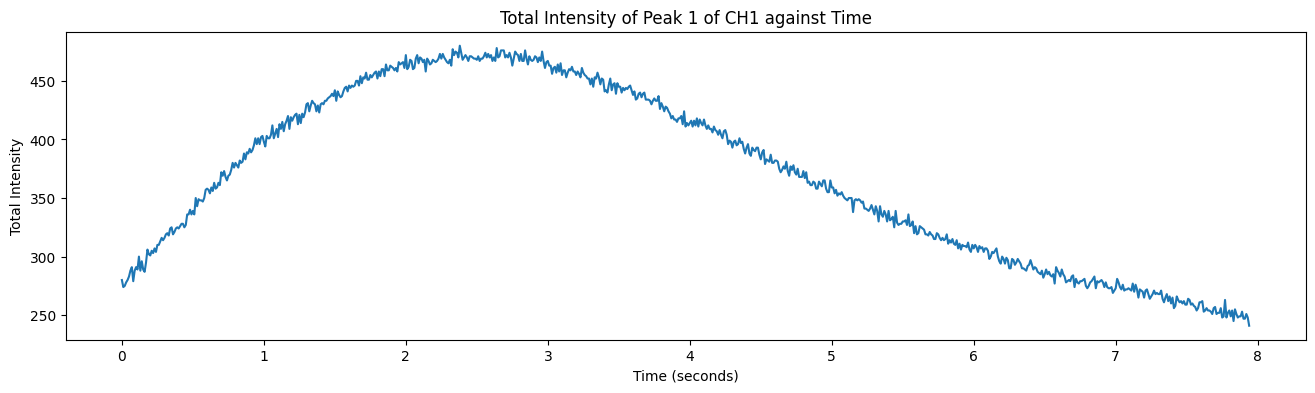

In [10]:
# plot tot_intensity_all_frames against time if each frame is 1/100 seconds
tf = len(tot_intensity_all_frames_p1_CH1)/100
tpf =  1/100

plt.figure(figsize=(16,4))
time = np.arange(0, tf, tpf)
plt.plot(time, tot_intensity_all_frames_p1_CH1)
plt.xlabel("Time (seconds)")
plt.ylabel("Total Intensity")
plt.title("Total Intensity of Peak 1 of CH1 against Time")
plt.show()

In [11]:
print(poly_pair_arr_CH2_tol4_10[0])

[491 388]


# Corresponding CH2 peak: [491, 388]

In [12]:
# mask_new has already been defined above !
tot_intensity_all_frames_p1_CH2 = []
for i in range(len(Frames_data)): #for i in range(795): i= 0, 1, 2,..., 794
    
    # transforms from 2D to 3D
    if Frames_data[i].ndim == 2:
        frame_3d = np.repeat(Frames_data[i][..., np.newaxis], 3, -1)
    elif Frames_data[i].ndim==3 and Frames_data[i].shape[2]==3:
        frame_3d = Frames_data[i]
    
    frame_3d[mask_new] = [255, 255, 0]
    total_intensity_p1_CH2,_ = intensity_in_circle(frame_3d, 4, 491, 388)
    tot_intensity_all_frames_p1_CH2.append(total_intensity_p1_CH2)

print(f"Total Intensity Array CH1 [:5]: {tot_intensity_all_frames_p1_CH1[:5]}")
print(f"Total Intensity Array CH2 [:5]: {tot_intensity_all_frames_p1_CH2[:5]}")

Total Intensity Array CH1 [:5]: [280, 274, 275, 278, 280]
Total Intensity Array CH2 [:5]: [264, 263, 266, 268, 267]


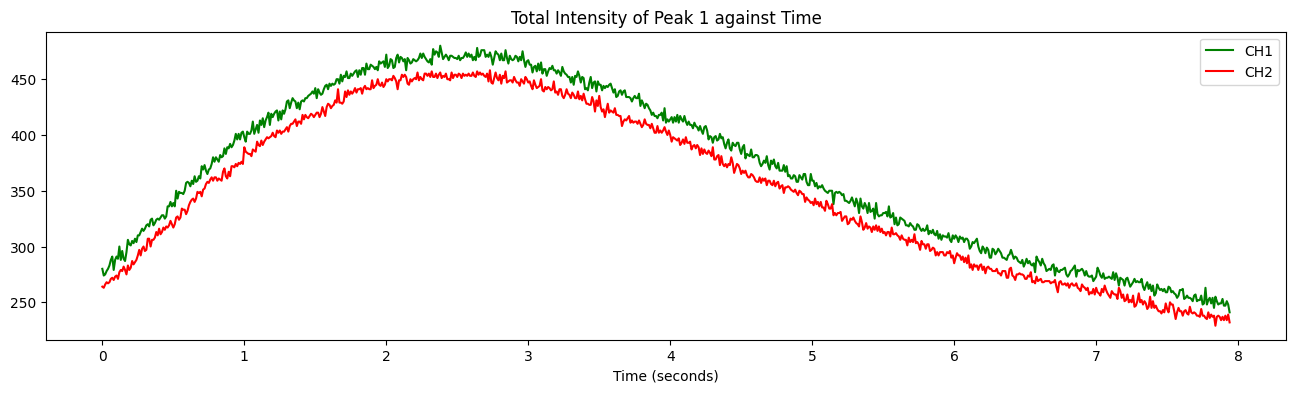

In [14]:

plt.figure(figsize=(16,4))
time = np.arange(0, tf, tpf)

plt.plot(time, tot_intensity_all_frames_p1_CH1, color='green', label='CH1')
plt.title("Total Intensity of Peak 1 against Time")
plt.plot(time, tot_intensity_all_frames_p1_CH2, color='red', label='CH2')
plt.legend()
plt.xlabel("Time (seconds)")
plt.show()